# DeepDetect (Binary) — ResNet50




This project aims to perform binary image classification, distinguishing between two classes in this case, real vs fake images.
The system is built using Deep Learning techniques, specifically Convolutional Neural Networks (CNNs) implemented with TensorFlow and Keras.

### **Project Objective**

To train a deep learning model capable of learning meaningful visual patterns that allow it to classify unseen images accurately, while also understanding why the model makes certain predictions through visual interpretation methods like Grad-CAM.

### **Why ResNet50?**

We chose ResNet50 as the backbone for several key reasons:



*   **Texture sensitivity:** ResNet50’s convolutional blocks are highly effective at capturing fine-grained surface details such as skin tone gradients, lighting reflections, and noise artifacts all crucial cues for identifying manipulated visuals.

*   **Robustness to image variation:** Since our dataset includes images with different backgrounds, lighting, and compression levels, the skip-connection design helps the network maintain strong feature propagation and avoid overfitting to minor visual noise.

*   **Transfer learning advantage:** By starting from ImageNet pre-trained weights, the model already understands general visual patterns (edges, shapes, colors), allowing faster convergence and higher accuracy even with limited training data.

*  **Efficient adaptation for binary tasks:** Compared to heavier architectures (e.g., EfficientNet or DenseNet), ResNet50 offers an optimal trade-off between depth and computational cost, which fits our project’s scale and available GPU resources.

### **Setup and import dependencies**

In [10]:
import os, json, glob, shutil, zipfile, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')


print("TF:", tf.__version__)
print("Keras API:", keras.__version__)
print("NumPy:", np.__version__)


DATASET_SRC = DATASET_SRC = "/content/drive/MyDrive/dataset"
OUTPUT_DIR  = "/content/drive/MyDrive/deepdetect_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Output dir:', OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TF: 2.19.0
Keras API: 3.10.0
NumPy: 2.0.2
Output dir: /content/drive/MyDrive/deepdetect_outputs


### **find and prepare the dataset folders for training, validation, and testing.**

In [11]:
def _children(d):
    return [n for n in os.listdir(d) if os.path.isdir(os.path.join(d, n))]

def _looks_like_split_root(d):
    names = [n.lower() for n in _children(d)]
    has_train = any('train' in n or 'training' in n for n in names)
    has_test  = any('test'  in n or 'testing'  in n for n in names)
    has_val   = any('val'   in n or 'valid'    in n for n in names)
    return (has_train and has_test) or (has_train and has_val)

def ensure_dataset_root(src_path):
    if os.path.isdir(src_path):
        root = src_path
    elif os.path.isfile(src_path) and src_path.lower().endswith('.zip'):
        target_root = '/content/dataset_unzipped'
        if os.path.exists(target_root):
            shutil.rmtree(target_root)
        os.makedirs(target_root, exist_ok=True)
        print(f"[INFO] Unzipping: {src_path} -> {target_root}")
        with zipfile.ZipFile(src_path, 'r') as z:
            z.extractall(target_root)
        root = target_root
    else:
        raise FileNotFoundError(f'Not found or unsupported: {src_path}')

    queue, visited, depth = [root], set(), {root: 0}
    while queue:
        p = queue.pop(0)
        if p in visited or depth[p] > 3:
            continue
        visited.add(p)
        if _looks_like_split_root(p):
            return p
        for c in _children(p):
            cp = os.path.join(p, c)
            depth[cp] = depth[p] + 1
            queue.append(cp)

    for c in _children(root):
        if c.lower() == 'dataset':
            return os.path.join(root, c)
    return root

def discover_split_names(root):
    name_map = {'train': None, 'val': None, 'test': None}
    for d in _children(root):
        low = d.lower()
        if ('train' in low or 'training' in low) and name_map['train'] is None:
            name_map['train'] = d
        elif ('val' in low or 'valid' in low or 'validation' in low) and name_map['val'] is None:
            name_map['val'] = d
        elif ('test' in low or 'testing' in low) and name_map['test'] is None:
            name_map['test'] = d
    if name_map['train'] is None or name_map['test'] is None:
        raise RuntimeError(f'Could not detect split folders under: {root}\nFound: {_children(root)}')
    return name_map

DATASET_DIR = ensure_dataset_root(DATASET_SRC)
SPLIT_NAME_MAP = discover_split_names(DATASET_DIR)
USE_VAL_DIR = SPLIT_NAME_MAP['val'] is not None
print('[INFO] DATASET_DIR =', DATASET_DIR)
print('[INFO] Splits map  =', SPLIT_NAME_MAP)
print('GPU:', tf.config.list_physical_devices('GPU'))

[INFO] DATASET_DIR = /content/drive/MyDrive/dataset
[INFO] Splits map  = {'train': 'train', 'val': 'val', 'test': 'test'}
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **loads and prepares the image dataset by creating training, validation, and test splits from the detected folders.**

In [14]:
IMG_SIZE   = (256, 256)
BATCH_SIZE = 4
SEED       = 42
EPOCHS     = 15
STEPS_PER_EPOCH  = 4000
VALIDATION_STEPS = 250

def build_dataset(split):
    real = SPLIT_NAME_MAP[split]
    split_dir = os.path.join(DATASET_DIR, real)
    if split == 'train' and not USE_VAL_DIR:
        train_dir = os.path.join(DATASET_DIR, SPLIT_NAME_MAP['train'])
        ds_train = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir, labels='inferred', label_mode='int',
            image_size=IMG_SIZE, batch_size=BATCH_SIZE,
            validation_split=0.15, subset='training', seed=SEED)
        ds_val = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir, labels='inferred', label_mode='int',
            image_size=IMG_SIZE, batch_size=BATCH_SIZE,
            validation_split=0.15, subset='validation', seed=SEED)
        return ds_train, ds_val
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        split_dir, labels='inferred', label_mode='int', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=(split!='test'), seed=(SEED if split!='test' else None))
    return ds

if USE_VAL_DIR:
    train_ds = build_dataset('train')
    val_ds   = build_dataset('val')
else:
    train_ds, val_ds = build_dataset('train')
test_ds = build_dataset('test')

class_names = getattr(train_ds, 'class_names', None) or getattr(val_ds, 'class_names')
print('Classes:', class_names)

Found 140120 files belonging to 2 classes.
Found 39429 files belonging to 2 classes.
Found 10906 files belonging to 2 classes.
Classes: ['Fake', 'Real']


### Preview Dataset Samples

Before starting model training, we display a sample of images from each dataset split (training, validation, and testing).  
This helps verify that:
- Data is loaded correctly  
- Labels are mapped properly  
- Images are preprocessed correctly  


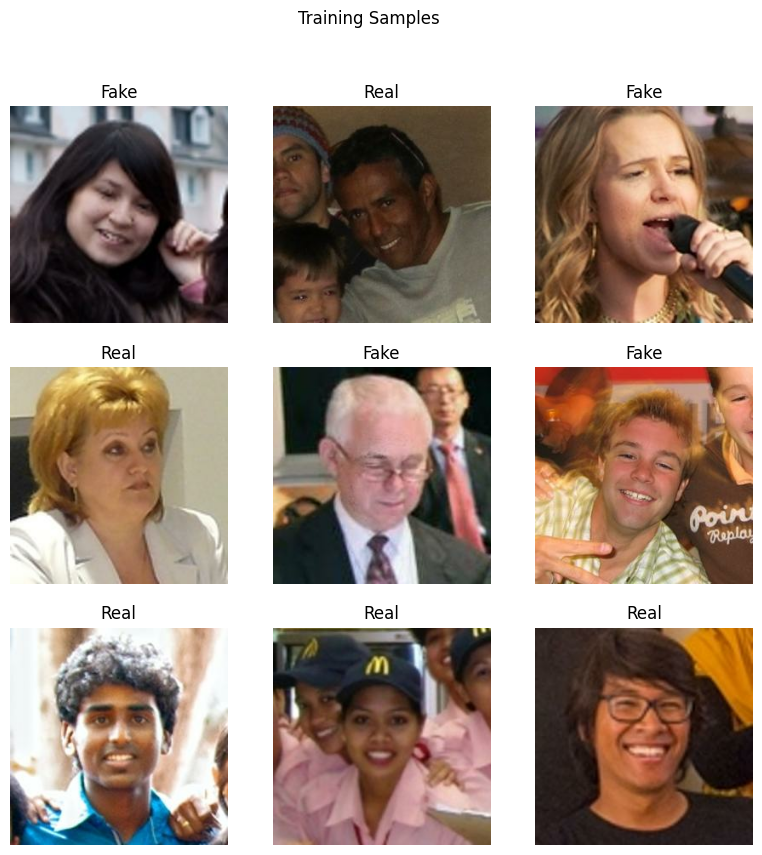

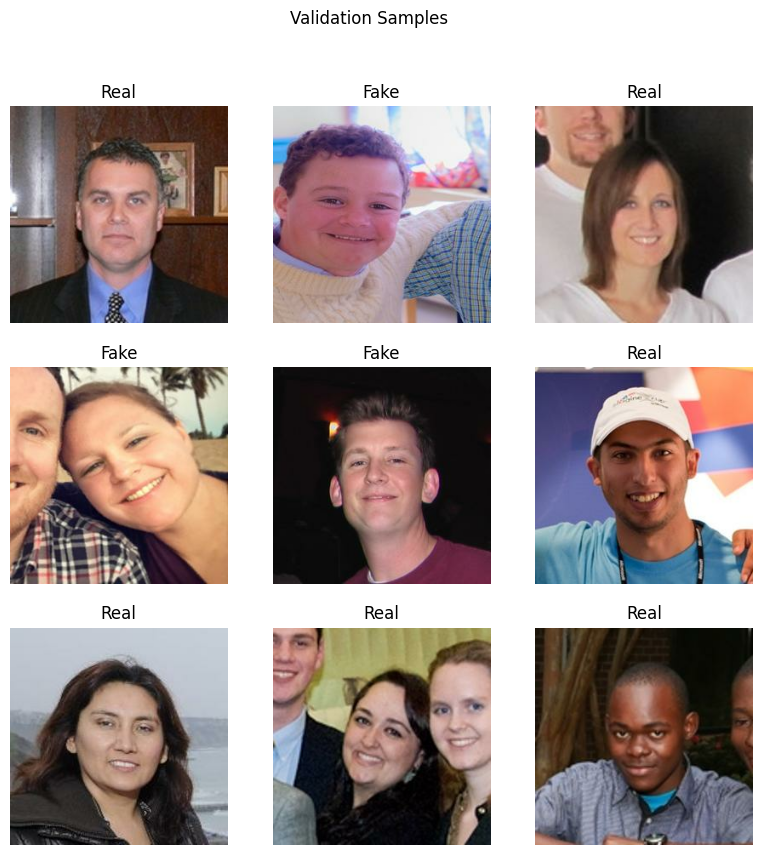

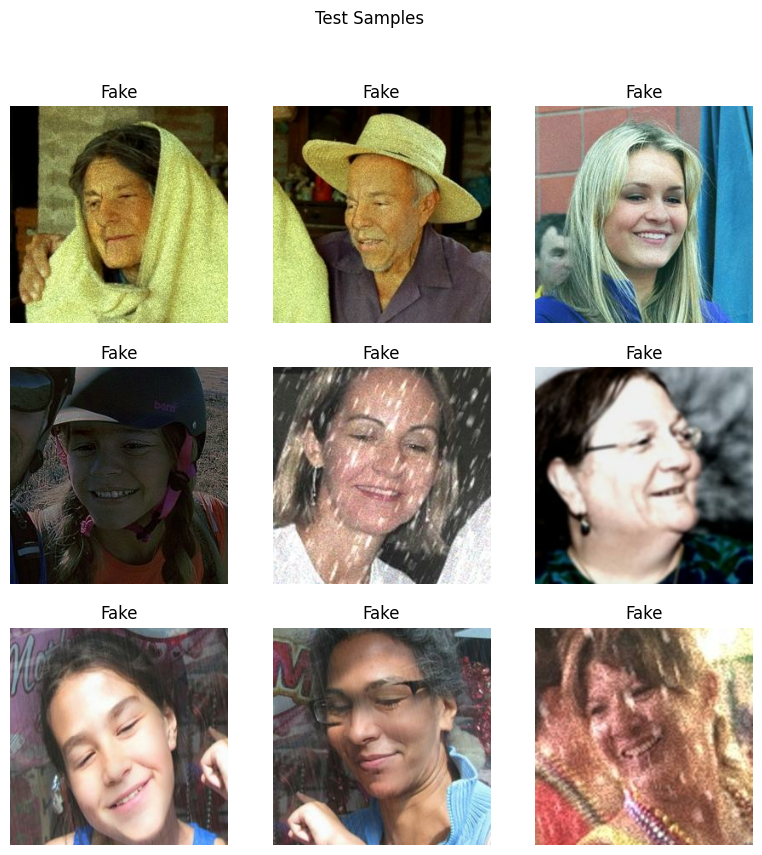

In [19]:

def _to_display_range(img):
    # (H,W,1) → (H,W)
    if img.ndim == 3 and img.shape[-1] == 1:
        img = img[..., 0]

    if img.dtype == np.uint8:
        return img

    img = img.astype(np.float32)
    vmin, vmax = float(img.min()), float(img.max())

    if vmin >= 0.0 and vmax <= 1.0:
        return img
    if vmin >= -1.0 and vmax <= 1.0:
        return (img + 1.0) / 2.0
    if vmax > 1.5:
        return img / 255.0

    return np.clip(img, 0.0, 1.0)

def show_samples(dataset, title, class_names, n=9):
    single = dataset.unbatch().take(n)

    imgs, labs = [], []
    for img, lab in single:
        imgs.append(img.numpy())
        labs.append(lab.numpy())

    if not imgs:
        print(f"[{title}] No samples to display.")
        return

    labs = np.array(labs)
    if labs.ndim > 1:
        labs = labs.argmax(axis=-1)

    k = len(imgs)
    cols = min(3, k)
    rows = int(np.ceil(k / cols))

    plt.figure(figsize=(cols * 3.2, rows * 3.2))
    for i in range(k):
        ax = plt.subplot(rows, cols, i + 1)
        img = _to_display_range(imgs[i])
        cmap = 'gray' if (img.ndim == 2) else None
        plt.imshow(img, cmap=cmap)
        plt.title(class_names[int(labs[i])])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



class_names = train_ds.class_names

show_samples(train_ds, "Training Samples", class_names)
show_samples(val_ds, "Validation Samples", class_names)
show_samples(test_ds, "Test Samples", class_names)


### **optimize the TensorFlow data pipeline.**
It caches, shuffles, and prefetches images to speed up training and ensure smoother GPU performance  reducing loading delays and improving overall efficiency.


In [ ]:
from datetime import datetime
RUN_ID = datetime.now().strftime('%Y%m%d_%H%M%S')

for p in glob.glob('/content/cache_*'):
    try:
        shutil.rmtree(p, ignore_errors=True)
    except Exception:
        pass

CACHE_VAL_TEST = False

def cfg(ds, *, split, training=False, cache_ok=True):
    if cache_ok:
        cache_path = f'/content/cache_{split}_{RUN_ID}'
        ds = ds.cache(cache_path)
    if training:
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    ds = ds.prefetch(1)
    opt = tf.data.Options(); opt.experimental_deterministic = False
    return ds.with_options(opt)

train_ds = cfg(train_ds, split='train', training=True,  cache_ok=True)
val_ds   = cfg(val_ds,   split='val',   training=False, cache_ok=CACHE_VAL_TEST)
test_ds  = cfg(test_ds,  split='test',  training=False, cache_ok=CACHE_VAL_TEST)
print('Pipelines ready.')

Pipelines ready.


## **improveing speed and data diversity**
mixed precision (float16) to boost GPU performance and reduce memory use, and  **simple data augmentation** (flip, rotate, zoom) to help the model generalize better and prevent overfitting.

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name='augmentation')
print('Mixed precision & augmentation ready.')

Mixed precision & augmentation ready.


### **Build the DeepDetect Model using ResNet50**

We define a custom Binary F1 metric to capture the balance between precision and recall, which is crucial for binary classification where classes (Fake vs Real) may be imbalanced.

Then, we construct the DeepDetect model by using ResNet50 (pre-trained on ImageNet) as a frozen feature extractor and add new layers Global Average Pooling, Dropout, and a Dense (sigmoid) output layer to specialize it for our task.

In [ ]:
class BinaryF1(keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]) >= self.threshold, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1.0 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1.0 - y_pred))
        self.tp.assign_add(tp); self.fp.assign_add(fp); self.fn.assign_add(fn)
    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall    = self.tp / (self.tp + self.fn + 1e-8)
        return 2.0 * precision * recall / (precision + recall + 1e-8)
    def reset_state(self):
        for v in (self.tp, self.fp, self.fn): v.assign(0.0)

base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
model = keras.Model(inputs, outputs, name='DeepDetect_ResNet50')
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DeepDetect_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

he summary shows a total of 23.6M parameters, but only 2K are trainable (the new top layers).
This means the model leverages ResNet50’s learned visual features while only learning task-specific weights leading to faster training, reduced overfitting, and strong performance on real vs fake image classification.

### **Compile Model and Set Callbacks**

 we compile the model using learning rate = 1e-4 and Binary Crossentropy as the loss function, which is ideal for binary classification.

We also include several evaluation metrics to get a complete view of model performance beyond accuracy alone.

To ensure stable and efficient training, three callbacks are configured:


*   **ModelCheckpoint:** saves the model only when it achieves the best validation F1 score.

*   **EarlyStopping:** stops training if validation performance stops improving to avoid overfitting.

*   **ReduceLROnPlateau:** lowers the learning rate when progress stalls, helping the model refine learning.











In [ ]:
metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           BinaryF1(name='f1', threshold=0.5)]

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics)

ckpt_path = os.path.join(OUTPUT_DIR, 'best_resnet50.keras')
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_f1', mode='max', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
print('Compiled. Callbacks ready.')

Compiled. Callbacks ready.


### **Train the model (frozen ResNet50) with validation monitoring**

We launch training on the repeated train_ds with fixed steps per epoch, validate on val_ds, and use callbacks (Checkpoint, EarlyStopping, ReduceLROnPlateau) to save the best val F1, stop early, and lower LR when progress stalls.

In [ ]:
hist = model.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
3996/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6033 - f1: 0.6125 - loss: 0.6786 - precision: 0.6006 - recall: 0.6254
Epoch 1: val_f1 improved from -inf to 0.76531, saving model to /content/drive/MyDrive/deepdetect_outputs/best_resnet50.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.6034 - f1: 0.6126 - loss: 0.6785 - precision: 0.6007 - recall: 0.6254 - val_accuracy: 0.7700 - val_f1: 0.7653 - val_loss: 0.4978 - val_precision: 0.7979 - val_recall: 0.7353 - learning_rate: 1.0000e-04
Epoch 2/15
3995/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7277 - f1: 0.7312 - loss: 0.5416 - precision: 0.7109 - recall: 0.7528
Epoch 2: val_f1 did not improve from 0.76531
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7277 - f1: 0.7312 - loss: 0.5416 - precision: 0.7109 - recall: 0.7528 - val_accuracy: 0.7650 - val_f1: 0.7392 - val_loss: 0.4817 - val_precision: 0.8517 - val_recall: 0.6529 - learning_rate: 1.0000e-04
Epoch 3/15
3999/4000 ━━━━━━━━━━━

Rapid improvement early val_f1 = 0.765 (epoch 1), small gains to 0.775 (epoch 6), and the best = 0.7827 at epoch 9.

LR reductions at epochs 8, 11, 13 indicate plateaus; training stabilizes after that.

Accuracy hovers ~0.77–0.79 with val_loss ~0.44–0.47 reasonable for the frozen-backbone stage.

the frozen ResNet50 features are working; the top head converged. Next step is to push validation F1 higher.

### **Visualize Training Progress**

This function plots the training and validation curves for key metrics loss, accuracy, and F1 across all epochs. It helps visualize how well the model learned and whether it overfitted or underfitted.

Saved: /content/drive/MyDrive/deepdetect_outputs/training_curves.png


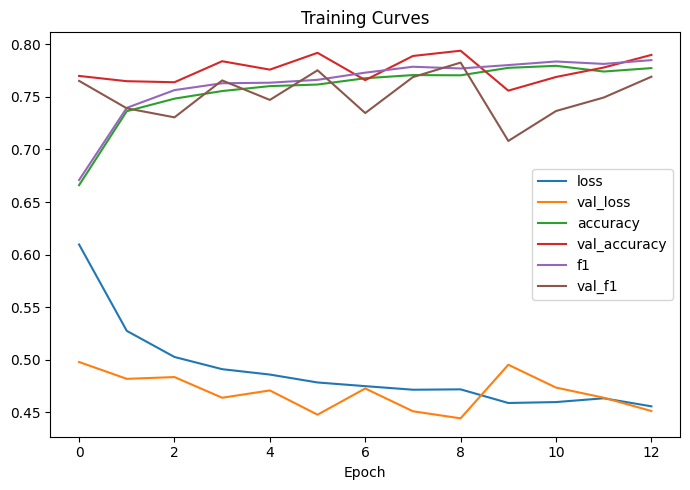

In [ ]:
def plot_history(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch'); ax.set_title('Training Curves'); ax.legend(); fig.tight_layout()
    out = os.path.join(OUTPUT_DIR, 'training_curves.png'); fig.savefig(out, dpi=160)
    print('Saved:', out)
plot_history(hist)

The plotted curves show how the model improved during training. Loss decreased steadily, while accuracy and F1-score rose and stabilized around 0.78–0.80. The close alignment between training and validation curves indicates good generalization and minimal overfitting.

### **Test evaluation**

we evaluate how well the pretrained ResNet50 model performs on the unseen test dataset. The purpose of this step is to measure the baseline performance how much the model can already distinguish between real and fake images without additional fine-tuning.

This evaluation uses the model’s predictions to compute a classification report and a confusion matrix, providing detailed insights into the model’s strengths


Classification Report (pre-FT):
              precision    recall  f1-score   support

        Fake     0.6625    0.8461    0.7432      5492
        Real     0.7828    0.5627    0.6548      5413

    accuracy                         0.7055     10905
   macro avg     0.7227    0.7044    0.6990     10905
weighted avg     0.7222    0.7055    0.6993     10905

Saved: /content/drive/MyDrive/deepdetect_outputs/confusion_matrix_preFT.png


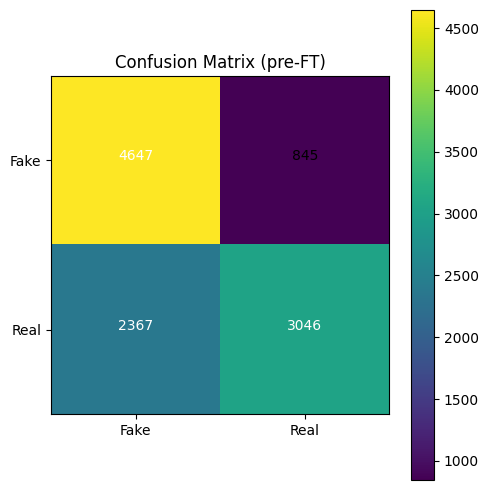

In [ ]:
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().tolist())
    y_pred.extend((probs >= 0.5).astype(int).tolist())
y_true = np.array(y_true); y_pred = np.array(y_pred)

print('\nClassification Report (pre-FT):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (pre-FT)')
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], 'd'), ha='center', color=('white' if cm[i,j]>th else 'black'))
fig.colorbar(im); fig.tight_layout()
out = os.path.join(OUTPUT_DIR, 'confusion_matrix_preFT.png'); fig.savefig(out, dpi=160)
print('Saved:', out)

This report shows the model’s performance on the test split using a 0.5 threshold. Overall accuracy is ~0.71. For Fake, recall is high (0.846) the model catches most fake images (TP=4647, FN=845). For Real, recall is lower (0.563) many real images are flagged as fake (FN for Real = 2367 vs TP=3046), which is also why precision for Real (0.783) is good but recall lags. The confusion matrix confirms a bias toward predicting "Fake".

Next steps to improve: fine-tune the backbone, consider class weights/imbalance handling.

### **Fine-tuning setup**

 re-enables training for the deeper layers of ResNet50 to let the model adapt its high-level features to the deepfake dataset while keeping the early convolutional layers frozen to preserve general visual features.

In [ ]:
base.trainable = True
for layer in base.layers[:-80]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(3e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       BinaryF1(name='f1', threshold=0.5)])
print('Fine-tune setup done.')

Fine-tune setup done.


### **Fine-tuning training run**

 training after unfreezing the top of ResNet-50. We call model.fit on the same pipeline but with a smaller LR (3e-5), limited epochs (4), and the same callbacks:

ModelCheckpoint keeps the best weights by val_f1.

ReduceLROnPlateau halves LR when validation loss stalls.

(EarlyStopping remains available via the checkpointed best model).

Because the datasets are streaming, we use repeat() with fixed steps_per_epoch/validation_steps to cap epoch time.

Epoch 1/4
3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8756 - f1: 0.8761 - loss: 0.2861 - precision: 0.8800 - recall: 0.8732
Epoch 1: val_f1 improved from 0.78270 to 0.91919, saving model to /content/drive/MyDrive/deepdetect_outputs/best_resnet50.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 137s 20ms/step - accuracy: 0.8756 - f1: 0.8761 - loss: 0.2861 - precision: 0.8800 - recall: 0.8732 - val_accuracy: 0.9200 - val_f1: 0.9192 - val_loss: 0.2615 - val_precision: 0.9459 - val_recall: 0.8939 - learning_rate: 3.0000e-05
Epoch 2/4
3998/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9546 - f1: 0.9553 - loss: 0.1243 - precision: 0.9507 - recall: 0.9600
Epoch 2: val_f1 improved from 0.91919 to 0.95238, saving model to /content/drive/MyDrive/deepdetect_outputs/best_resnet50.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - accuracy: 0.9546 - f1: 0.9553 - loss: 0.1243 - precision: 0.9507 - recall: 0.9600 - val_accuracy: 0.9510 - val_f1: 0.9524 - val_loss: 0.1259 - val_precision: 0

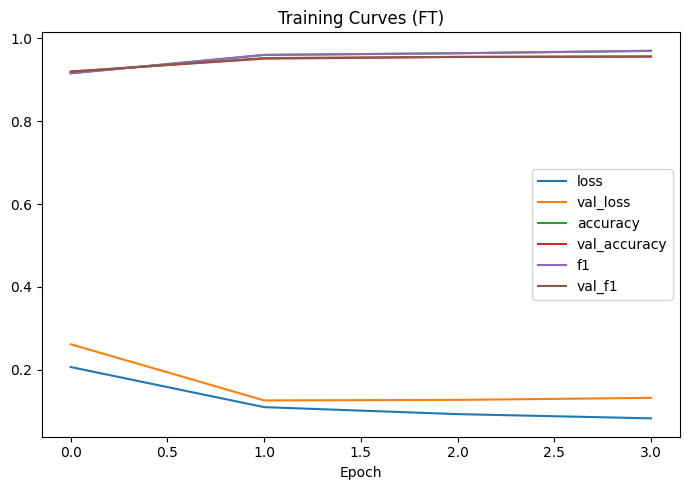

In [ ]:
hist_ft = model.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)
def plot_history_ft(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch'); ax.set_title('Training Curves (FT)'); ax.legend(); fig.tight_layout()
    out = os.path.join(OUTPUT_DIR, 'training_curves_ft.png'); fig.savefig(out, dpi=160)
    print('Saved:', out)
plot_history_ft(hist_ft)

After fine-tuning, the model’s validation F1 score surged from around 0.78 to 0.956, with validation accuracy stabilizing between 95–96%. Both loss and validation loss dropped sharply before leveling off, indicating that training converged smoothly. Accuracy and F1 metrics for both training and validation remained closely aligned, showing no signs of overfitting. Toward the final epoch, the learning rate automatically decreased, which helped refine and stabilize the final performance plateau.

### **Final Evaluation**

evaluateing the fine-tuned model on the test dataset to assess its real-world performance.


FINAL Test Report (after FT):
              precision    recall  f1-score   support

        Fake     0.7626    0.9609    0.8503      5492
        Real     0.9460    0.6965    0.8023      5413

    accuracy                         0.8296     10905
   macro avg     0.8543    0.8287    0.8263     10905
weighted avg     0.8536    0.8296    0.8265     10905

Saved: /content/drive/MyDrive/deepdetect_outputs/confusion_matrix_postFT.png
Artifacts saved to: /content/drive/MyDrive/deepdetect_outputs


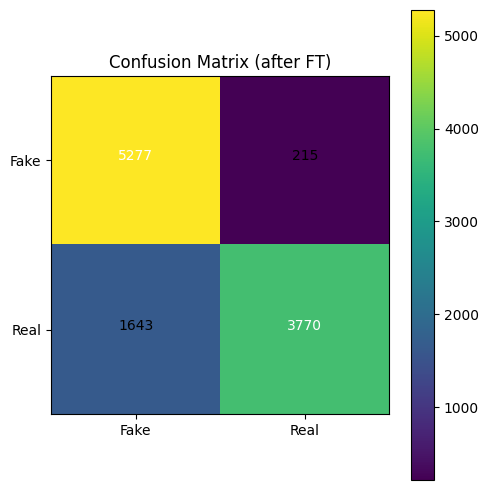

In [ ]:
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().tolist())
    y_pred.extend((probs >= 0.5).astype(int).tolist())
y_true = np.array(y_true); y_pred = np.array(y_pred)

print('\nFINAL Test Report (after FT):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (after FT)')
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], 'd'), ha='center', color=('white' if cm[i,j]>th else 'black'))
fig.colorbar(im); fig.tight_layout()
out = os.path.join(OUTPUT_DIR, 'confusion_matrix_postFT.png'); fig.savefig(out, dpi=160)
print('Saved:', out)

model.save(os.path.join(OUTPUT_DIR, 'final_model.keras'))
with open(os.path.join(OUTPUT_DIR, 'labels.json'), 'w') as f:
    json.dump({'classes': class_names}, f, indent=2)
with open(os.path.join(OUTPUT_DIR, 'test_metrics.json'), 'w') as f:
    json.dump({'accuracy': float(accuracy_score(y_true, y_pred)),
               'precision': float(precision_score(y_true, y_pred)),
               'recall': float(recall_score(y_true, y_pred)),
               'f1': float(f1_score(y_true, y_pred)),
               'confusion_matrix': cm.tolist()}, f, indent=2)
print('Artifacts saved to:', OUTPUT_DIR)

After fine-tuning, the model achieved a strong overall improvement, reaching 82.9% accuracy on the final test set. The Fake class showed higher recall (0.96), meaning the model became excellent at detecting fake images, while the Real class had higher precision (0.94), showing it rarely mislabeled real samples as fake. This balance reflects that the model learned to distinguish authenticity more confidently, though it still slightly favors detecting fakes. The confusion matrix confirms this: most fake samples (5277/5492) were correctly identified, and real ones (3770/5413) were mostly accurate. Overall, fine-tuning significantly enhanced robustness and generalization compared to pre-FT performance.

###  Sample Model Predictions (Real vs Fake)

Below are random prediction samples from the **Test** and **Validation** datasets.
Each image is labeled as:
**Predicted : True**  
Green = Correct prediction  
Red = Wrong prediction


In [33]:
from tensorflow import keras

model_path = "/content/drive/MyDrive/deepdetect_outputs/best_resnet50.keras"
model = keras.models.load_model(model_path, compile=False)

print("Model loaded:", model_path)



Model loaded: /content/drive/MyDrive/deepdetect_outputs/best_resnet50.keras


In [34]:
import math

try:
    _to_display_range
except NameError:
    def _to_display_range(img):
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        img = img.astype("float32")
        return np.clip(img, 0, 1)

def _ensure_probs(pred):
    pred = np.array(pred)
    if pred.ndim == 2 and pred.shape[1] == 1:  # binary
        p1 = pred[:, 0]
        return np.stack([1 - p1, p1], axis=1)
    return pred  # multiclass ready

def display_predictions(dataset, model, class_names, n=24, cols=8,
                        title_mode="name", save_png=False, png_name="predictions.png"):
    imgs, labs = [], []
    for img, lab in dataset.unbatch().take(n):
        imgs.append(img.numpy())
        labs.append(lab.numpy())
    labs = np.array(labs)
    if labs.ndim > 1:
        labs = labs.argmax(axis=-1)

    x = np.stack(imgs, axis=0)
    raw_pred = model.predict(x, verbose=0)
    probs = _ensure_probs(raw_pred)
    pred_idx = probs.argmax(axis=1)

    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 2.2, rows * 2.2))

    for i in range(n):
        disp = _to_display_range(imgs[i])
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(disp, cmap="gray" if disp.ndim == 2 else None)
        correct = pred_idx[i] == labs[i]
        if title_mode == "name":
            title = f"{class_names[pred_idx[i]]} : {class_names[labs[i]]}"
        plt.title(title, color=("green" if correct else "red"))
        plt.axis("off")

    if save_png:
        plt.savefig(png_name, dpi=200, bbox_inches="tight")
    plt.show()


**Display Sample Validation Results**

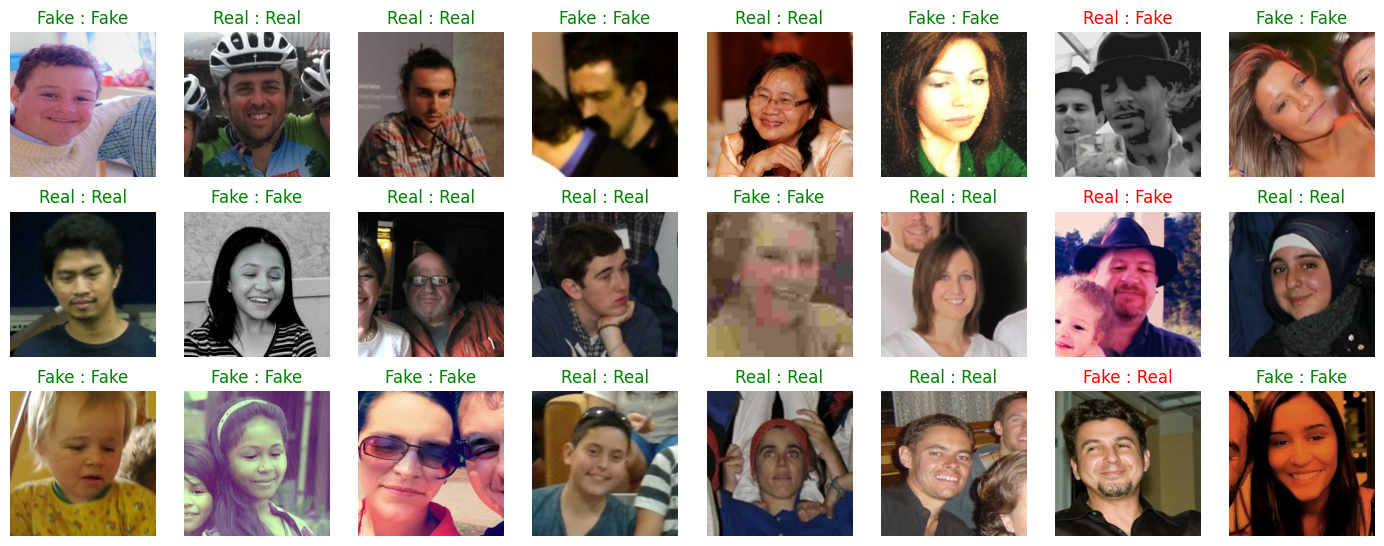

In [37]:
# validation dataset
display_predictions(
    val_ds, model,
    class_names=train_ds.class_names,
    n=24, cols=8, title_mode="name",
    save_png=True, png_name="val_predictions_grid.png"
)

**Display Sample Test Results**

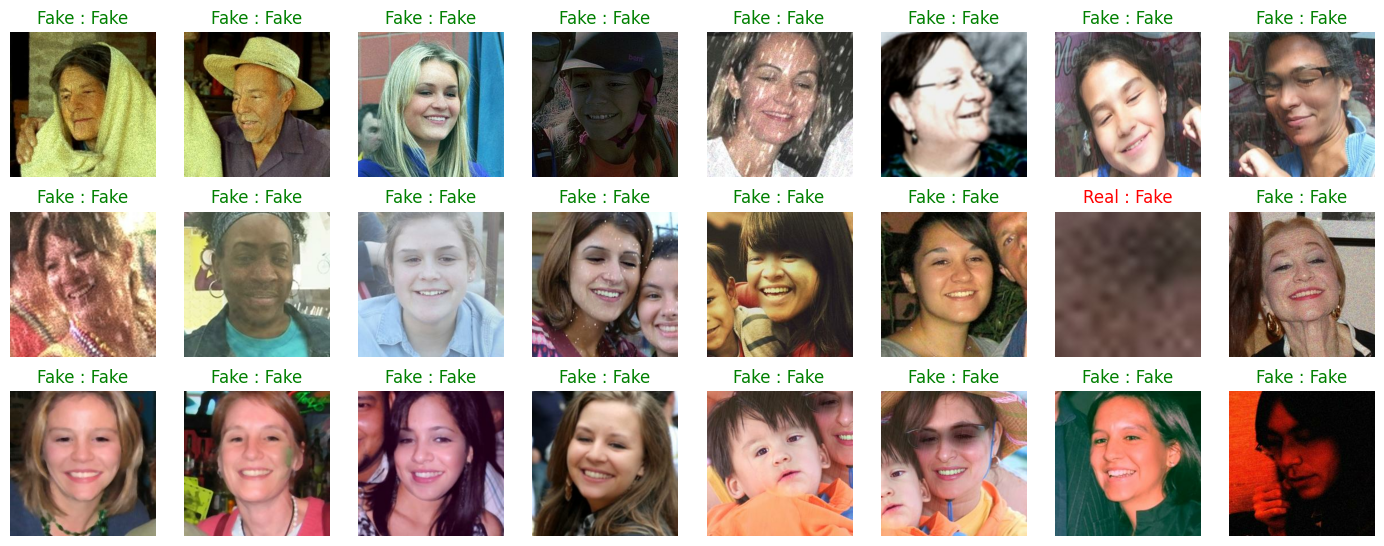

In [36]:
# test dataset
display_predictions(
    test_ds, model,
    class_names=train_ds.class_names,
    n=24, cols=8, title_mode="name",
    save_png=True, png_name="test_predictions_grid.png"
)



### **Grad-CAM Visualization for Model Interpretability**

we used Grad-CAM (Gradient-weighted Class Activation Mapping) to visually explain how the model makes its predictions. Grad-CAM highlights the specific regions in an image that most influenced the model’s decision. in this case, whether an image is real or fake. By computing gradients of the output class score with respect to the convolutional feature maps, the method produces a heatmap overlay showing areas of high importance (in red/yellow) and less influence (in blue).

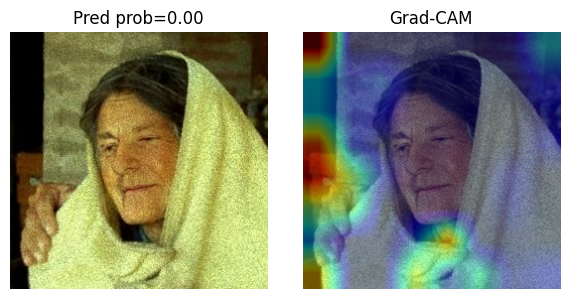

Saved: /content/drive/MyDrive/deepdetect_outputs/gradcam_example.png


In [ ]:

def grad_cam(img_tensor, model,
             backbone_name="resnet50",
             preprocess_fn=tf.keras.applications.resnet50.preprocess_input):

    aug_layer   = model.get_layer("augmentation")
    backbone    = model.get_layer(backbone_name)
    gap_layer   = next(l for l in model.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
    drop_layer  = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dropout))
    dense_orig  = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense))


    dense_new = tf.keras.layers.Dense(
        units=dense_orig.units, activation=dense_orig.activation, dtype="float32", name="dense_cam_tmp"
    )
    dense_new.build((None, backbone.output_shape[-1]))
    dense_new.set_weights(dense_orig.get_weights())


    with tf.GradientTape() as tape:
        x = aug_layer(img_tensor, training=False)
        x = preprocess_fn(x)
        conv_out = backbone(x, training=False)

        x2 = gap_layer(conv_out)
        x2 = drop_layer(x2, training=False)
        preds = dense_new(x2)

        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1).numpy()[0]
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = tf.image.resize(cam[..., None], img_tensor.shape[1:3]).numpy()[..., 0]
    return cam

for batch_imgs, _ in test_ds.take(1):
    img0  = batch_imgs[0:1]
    prob  = model.predict(img0, verbose=0)[0, 0]
    cam   = grad_cam(img0, model)
    img_d = img0[0].numpy().astype("uint8")

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img_d); plt.title(f"Pred prob={prob:.2f}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img_d); plt.imshow(cam, alpha=0.45, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.tight_layout()
    out = os.path.join(OUTPUT_DIR, "gradcam_example.png")
    plt.savefig(out, dpi=160); plt.show()
    print("Saved:", out)
    break


In the output, the left image shows the original sample that the model confidently classified as Fake (Pred prob = 0.00). The right image displays the Grad-CAM heatmap, highlighting the areas that most influenced the model’s decision.

Here, the warm colors (red and yellow) appear mostly around the shoulder, clothing, and background, rather than the face. This suggests that the model’s decision was influenced more by textural or lighting cues in those regions instead of facial features.

This insight is valuable because it helps us evaluate how the model interprets visual patterns — revealing that even when the prediction is correct, the model might rely on non-human cues (like noise or fabric texture). Grad-CAM therefore provides a way to audit and improve model focus, ensuring it learns meaningful visual reasoning rather than superficial patterns.